In [1]:
using Pkg

In [2]:
Pkg.activate(dirname(pwd()))

  Activating environment at `~/Documents/GitHub/ComputationalHeatTransfer.jl/Project.toml`


In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using CoolProp
using Interpolations
using JLD2
using Plots
gr()  

cd(dirname(pwd()))
cd("src") 
# includet("ComputationalHeatTransfer.jl")
# using ..ComputationalHeatTransfer
includet("OneDOHP.jl")
using ..OneDOHP

## Get fluid properties

In [4]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [5]:
using UnPack

p_fluid = get_saturation_property(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

## Read data

In [6]:
using JLD2

In [7]:
# OHPdata = load("OHP1_40W.jld2")
# OHPdata = load("OHP1_40W_bothPe7.jld2")
# OHPdata = load("OHP1_40W_bothfine.jld2")
# OHPdata = load("OHP2_40W_E075.jld2")
# OHPdata = load("OHP2_40W_E070.jld2")
# OHPdata = load("OHP2_40W_E068.jld2")
# OHPdata = load("OHP2_40W_E050.jld2")
OHPdata = load("OHP2_30W_E064_2_DT1.jld2")



Dict{String, Any} with 6 entries:
  "integrator_tube"  => t: 272.76620000335885…
  "integrator_plate" => t: 272.76620000335885…
  "ohp"              => Basic pointwise-specified body with 4877 points…
  "tube_hist"        => Any[t: 0.39960000000000734…
  "plate_T_hist"     => Any[Primal nodes in a (nx = 250, ny = 108) cell grid of…
  "boil_data"        => [65.0 268.3; 80.0 268.3; … ; 160.0 272.7; 216.0 272.7]

In [8]:
tube_hist = OHPdata["tube_hist"]
plate_T_hist = OHPdata["plate_T_hist"]
# plate_hist = load("plate_OHP1_40W.jld2")
integrator_plate = OHPdata["integrator_plate"]
sys = integrator_plate.p

sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

## Get RTD result for OHP

In [9]:
import XLSX

In [10]:
# xf = XLSX.readxlsx("20190613_F_PD_#004_O001_H001_P040_expA.xlsx")
# starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
# RTDt = (1:size(RTD,1)) .+ starti;

In [11]:
xf = XLSX.readxlsx("20190612_F_PD_#007_O002_H001_P030_expA.xlsx")
# xf = XLSX.readxlsx("20190613_F_PD_#008_O002_H001_P040_expA.xlsx")
starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
RTD = xf["Raw Data!U:AB"][starti:end,:];
RTDt = (1:size(RTD,1)) .+ starti;

In [12]:
inch = 2.54e-2;


# x = [-2.6inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];

## get and save temperature line graph

In [19]:
X =  VectorData(x,y);

In [20]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [21]:
ghist = []
thist = []

size(g)
for j = 1:length(g)
    gtemp = []
    for i = 1:length(plate_T_hist)
        H(g,plate_T_hist[i])
        append!(gtemp,deepcopy(g[j]))
    end
    push!(ghist,deepcopy(gtemp))
end



thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

## Dryness

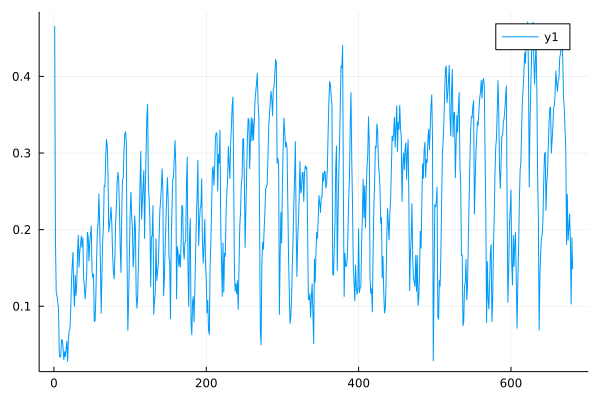

In [34]:
dryness = Float64[]
for sysfinali in sysfinal
    Lvaporplug = XptoLvaporplug(sysfinali.liquid.Xp,sysfinali.tube.L,sysfinali.tube.closedornot)
    Lvaporsum = sum(Lvaporplug)
    Ldryvapor = Lvaporplug - sysfinali.vapor.Lfilm_start  - sysfinali.vapor.Lfilm_end
    Ldrysum = sum(Ldryvapor)
    
    push!(dryness, Ldrysum/Lvaporsum)
end

plot(dryness)

## interface velocity curve

In [37]:
using Statistics

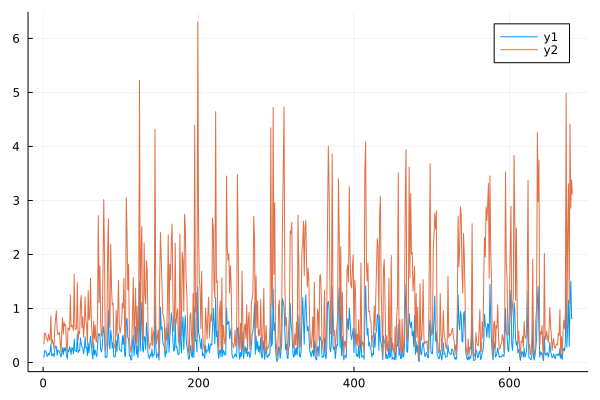

In [42]:
Vabs_avg = Float64[]
Vabs_max = Float64[]
for sysfinali in sysfinal
    V = [elem[2] for elem in sysfinali.liquid.dXdt]
    Vavg = mean(abs.(V))
    Vmax = maximum(abs.(V))
    
    push!(Vabs_avg, Vavg)
    push!(Vabs_max, Vmax)
end

plot(Vabs_avg)
plot!(Vabs_max)

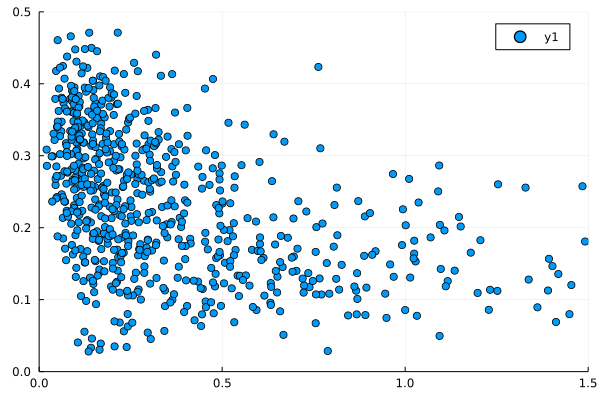

In [53]:
scatter(Vabs_avg,dryness,ylim=(0,0.5),xlim=(0,1.5))

In [29]:
V = [elem[2] for elem in sysfinal[end-5].liquid.dXdt]
Vavg = sum(abs.(V))/length(V)

0.00046841133513405436

In [30]:
addindex = 50:1:100
VArray = []
for i in addindex
VArray = [VArray;[elem[2] for elem in sysfinal[i].liquid.dXdt]]
end

## film δ distribution

In [ ]:
addindex = 50:1:300
δArray = []
for i in addindex
δArray = [δArray;sysfinal[i].vapor.δ]
end

In [ ]:
histogram(δArray,bins=2.0e-5:0.25e-6:3.0e-5,title="sum of δ from 50[s] : 1[s] : 100[s]",legend=false,xlabel="δ [m]",ylabel="N of vapor") 

In [ ]:
savefig("sum_film_thickness.svg")

In [ ]:
sysfinal[end].vapor.δ

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,25,100,300]
p1 = histogram(sysfinal[pltindex[1]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram(sysfinal[pltindex[2]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram(sysfinal[pltindex[3]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram(sysfinal[pltindex[4]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,xticks=2.5e-5:0.5e-5:3.5e-5,legend=false,xlabel="δ [m]",ylabel="N of vapor",plot_title="film thickness histogram")

In [ ]:
savefig("film_histogram.pdf")